Hand picking cases where LSTM gets fired (up or down)

In [1]:
# Import stuff

import numpy as np
import six
import tensorflow as tf
import time
import os
import seaborn as sns
from matplotlib import pyplot as plt

##### Using Shakespeare data: 

In [2]:
SHAKESPEARE_TXT = 'shakespeare.txt'

tf.logging.set_verbosity(tf.logging.INFO)

##### Function to convert text into integers thereby removing unwanted characters.

In [3]:
def transform(txt, pad_to=None):
    output = np.asarray([ord(c) for c in txt if ord(c) < 255], dtype=np.int32)
    if pad_to is not None:
        output = output[:pad_to]
        output = np.concatenate([
            np.zeros([pad_to - len(txt)], dtype=np.int32),
            output,
        ])
    return output

##### Defining the LSTM model with two layers.

In [4]:
EMBEDDING_DIM = 512

def lstm_model(seq_len=100, batch_size=None, stateful=True):
    """Language model: predict the next word given the current word."""
    source = tf.keras.Input(
      name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)

    embedding = tf.keras.layers.Embedding(input_dim=256, output_dim=EMBEDDING_DIM)(source)
    lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(embedding)
    print(lstm_1)
    lstm_2 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(lstm_1)
    predicted_char = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='softmax'))(lstm_2)
    model = tf.keras.Model(inputs=[source], outputs=[predicted_char,lstm_1,lstm_2])

    model.compile(
      optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
    return model

In [5]:
tf.keras.backend.clear_session()

### Make predictions with the model

Use the trained model to make predictions and generate your own Shakespeare-esque play.
Start the model off with a *seed* sentence, then generate 250 characters from it. The model makes five predictions from the initial seed.

In [6]:
BATCH_SIZE = 1


# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.

prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)

Tensor("lstm/transpose_1:0", shape=(1, 1, 512), dtype=float32)


In [7]:
prediction_model.load_weights('shakespeare_weights.h5')

##### Prediction Function:

This function takes a test text sequence and the trained model as inputs. <br>
It predicts the next character fo each input character from the input text sequence. Alongwith the generated output, we are also storing the LSTM cell states at each character level. The LSTM layer has 512 cells. Thus, we have (512 x len(input_text)) number of states at each layer. This model has two such LSTM layers.

In [8]:
def predict(seed_text, prediction_model):
    seed = transform(seed_txt)
    seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)
    PREDICT_LEN = len(seed_txt)-1
    print("Length of input text: " + str(PREDICT_LEN))
    
    predicted_char_o = []
    lstm_1_o = []
    lstm_2_o = []

    # First, run the seed forward to prime the state of the model.
    prediction_model.reset_states()
    for i in range(len(seed_txt) - 1):
        [predicted_char_temp,lstm_1_temp,lstm_2_temp] = prediction_model.predict(seed[:, i:i + 1])
        predicted_char_o.append(predicted_char_temp[0,0,:])
        lstm_1_o.append(lstm_1_temp[0,0,:])
        lstm_2_o.append(lstm_2_temp[0,0,:])
    return predicted_char_o,lstm_1_o,lstm_2_o

##### Analysis:

Now, we analyse some special cases by providing the input text accordingly. We plot the heat-map of the cell which shows high or low activation.

#### 1. White Space:

In [9]:
seed_txt = 'learn. do. you. see. full. stops. luck. lord.  hell. feel. good. trying. now. give it some    space'
predicted_text, lstm_1, lstm_2 = predict(seed_txt,prediction_model)

Length of input text: 98


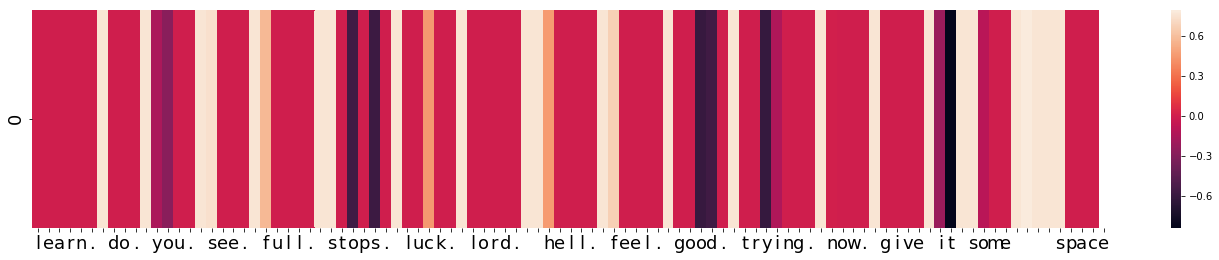

In [10]:
plt.figure(figsize=[24,4])
ax2 = sns.heatmap(np.array(lstm_1).T[130:131,:] ,xticklabels=list(seed_txt), )
ax2.tick_params(labelsize=18)
plt.show()

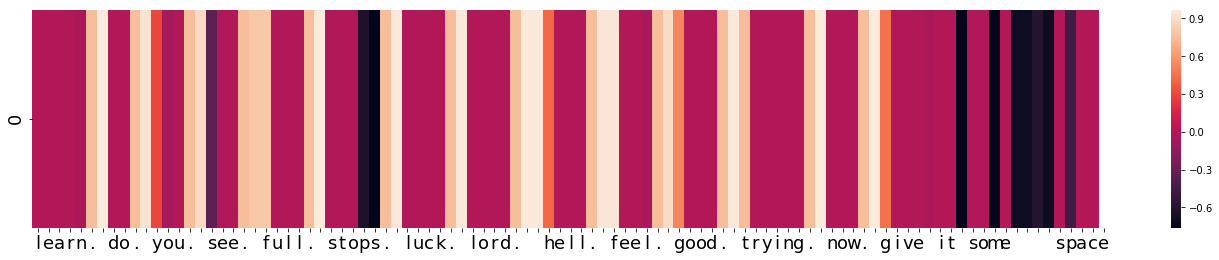

In [11]:
plt.figure(figsize=[24,4])
ax2 = sns.heatmap(np.array(lstm_2).T[257:258,:] ,xticklabels=list(seed_txt))
ax2.tick_params(labelsize=18)
plt.show()

#### 2. 'are':

#### 3. 'the' :

In [12]:
# We seed the model with our initial string, copied BATCH_SIZE times

#seed_txt = 'To hell with my vows of allegiance to you? '
seed_txt = 'you at there. see there you here whether then or weather the not the best the they the their che he yhe'
seed = transform(seed_txt)
seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)
PREDICT_LEN = len(seed_txt)-1
print(PREDICT_LEN)
print(seed.shape)


predicted_char_o = []
lstm_1_o = []
lstm_2_o = []

# First, run the seed forward to prime the state of the model.
prediction_model.reset_states()
for i in range(len(seed_txt) - 1):
    [predicted_char_temp,lstm_1_temp,lstm_2_temp] = prediction_model.predict(seed[:, i:i + 1])
    predicted_char_o.append(predicted_char_temp[0,0,:])
    lstm_1_o.append(lstm_1_temp[0,0,:])
    lstm_2_o.append(lstm_2_temp[0,0,:])

102
(1, 103)


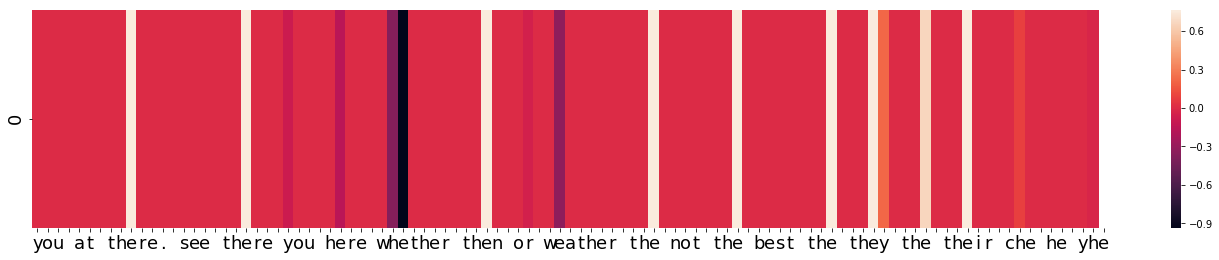

In [13]:
plt.figure(figsize=[24,4])
ax2 = sns.heatmap(np.array(lstm_2_o).T[94:95,:],xticklabels=list(seed_txt))
ax2.tick_params(labelsize=18)
plt.show()

#### 4. Capital Letters:

In [14]:
# We seed the model with our initial string, copied BATCH_SIZE times

#seed_txt = 'To hell with my vows of allegiance to you? '
seed_txt = 'heyaa HEY the YOU do get triggered HERE DHARA listen DOES do you TRIGGER at all CAPS hi HERE THERE'
#seed_txt = 'Hi. My name is TWISHA. How are YOU? I hope YOU are fine.'
seed = transform(seed_txt)
seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)
PREDICT_LEN = len(seed_txt)-1
print(PREDICT_LEN)

predicted_char_o = []
lstm_1_o = []
lstm_2_o = []

# First, run the seed forward to prime the state of the model.
prediction_model.reset_states()
for i in range(len(seed[0][:]) - 1):
    [predicted_char_temp,lstm_1_temp,lstm_2_temp] = prediction_model.predict(seed[:, i:i + 1])
    predicted_char_o.append(predicted_char_temp[0,0,:])
    lstm_1_o.append(lstm_1_temp[0,0,:])
    lstm_2_o.append(lstm_2_temp[0,0,:])

97


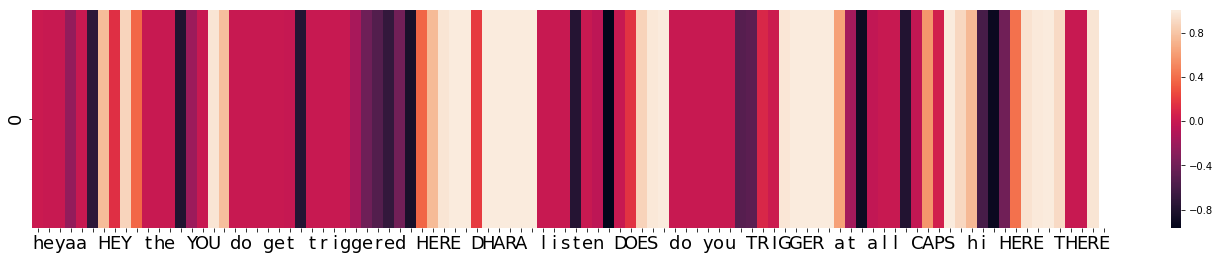

In [15]:
plt.figure(figsize=[24,4])
ax2 = sns.heatmap(np.array(lstm_2_o).T[257:258,:] ,xticklabels=list(seed_txt))
ax2.tick_params(labelsize=18)
plt.show()

Cell Numbers as observed:

1. Full Stops - 256:257 (lstm_1), 257:258 (lstm_2)
2. " " Inverted - Could not find any particular cell
3. the - 90:95 (lstm_2)
4. Capital Letters - 255:258 (lstm_2) (a bit delay observed in activation of cell)